In [ ]:
'''
This routine analyzes and visualizes the detected heatwave events, creating maps of heatwave days, number of events, and mean temperature thresholds.

Daniela Risaro
July 2025
'''


In [2]:
import xarray as xr
import numpy as np 
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


data_processed_dir = "../data/processed/"
data_raw_dir = "../data/raw/"

file_heatwaves = 'heatwaves_2015_2025_p95.nc'
ds_heatwaves = xr.open_dataset(data_processed_dir + file_heatwaves)

In [ ]:
heatwave_days = ds_heatwaves["event_dummy"].sum(dim="valid_time")

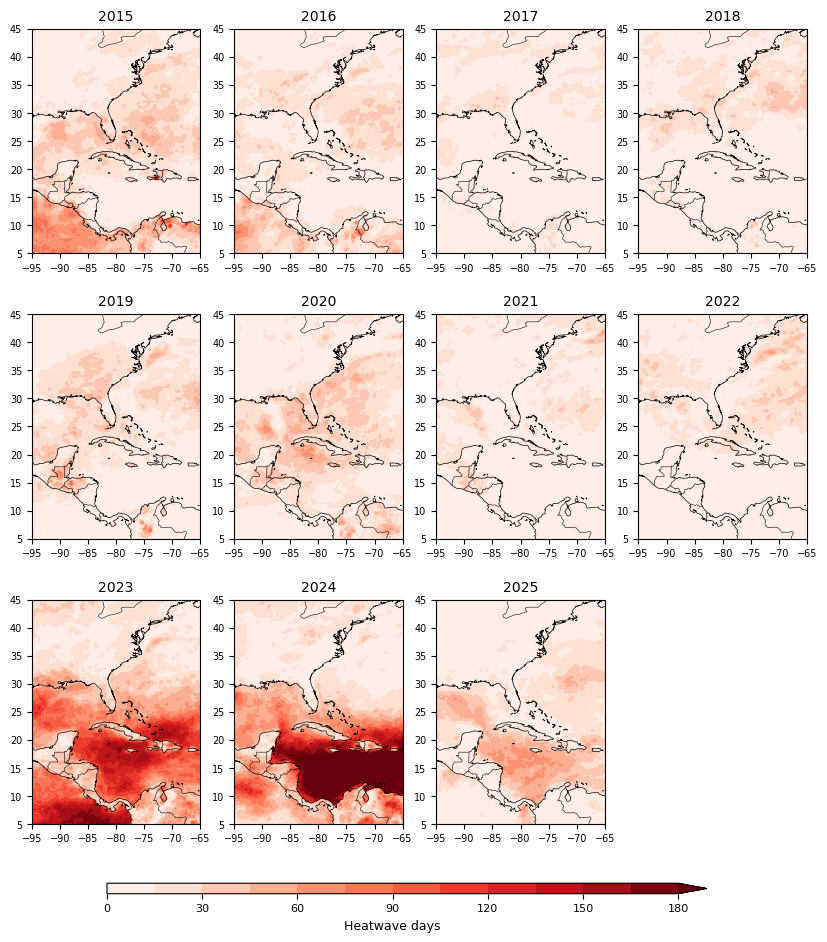

In [ ]:

vmin = 0
vmax = int(heatwave_days.max().values)
vmax = 180

years = ds_heatwaves.year.values
ncols = 4
nrows = int(np.ceil(len(years) / ncols))

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(2.5 * ncols, 3.5 * nrows),
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    hw_map = heatwave_days.sel(year=year)
    im = ax.contourf(ds_heatwaves.longitude, ds_heatwaves.latitude, hw_map,
                       cmap="Reds", vmin=vmin, vmax=vmax,
                       levels=np.arange(vmin, vmax+1, 15),
                       extend = 'max',
                       transform=ccrs.PlateCarree())
    ax.set_title(f"{year}", fontsize=10)
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor='black')
    ax.set_xticks(np.arange(-95, -64, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(5, 46, 5), crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.01])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Heatwave days", fontsize=9)
cbar.ax.tick_params(labelsize=8)



In [35]:
def count_events_1d(array_1d):
    array = np.asarray(array_1d).astype(float)
    array = np.nan_to_num(array, nan=0).astype(int)
    if array.ndim != 1:
        return np.nan  # fallback en caso de malformación
    padded = np.concatenate(([0], array, [0]))
    diff = np.diff(padded)
    return np.sum(diff == 1)

event_counts = xr.apply_ufunc(
    count_events_1d,
    ds_heatwaves["event_dummy"],
    input_core_dims=[["valid_time"]],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
)


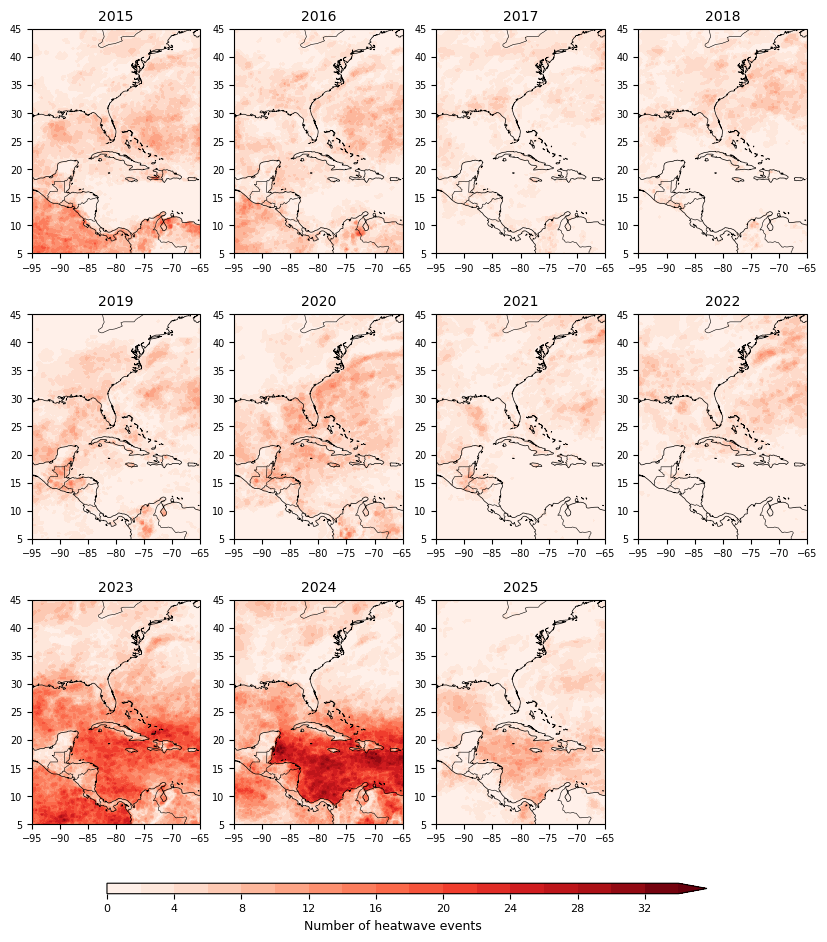

In [36]:

years = ds_heatwaves.year.values
vmin = 0
vmax = int(event_counts.max().values)

ncols = 4
nrows = int(np.ceil(len(years) / ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(2.5 * ncols, 3.5 * nrows),
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    map_data = event_counts.sel(year=year)
    im = ax.contourf(ds_heatwaves.longitude, ds_heatwaves.latitude, map_data,
                       cmap="Reds", levels=np.arange(vmin, vmax+1, 2),
                       extend = 'max',
                       transform=ccrs.PlateCarree())
    ax.set_title(f"{year}", fontsize=10)
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor='black')
    ax.set_xticks(np.arange(-95, -64, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(5, 46, 5), crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.01])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Number of heatwave events", fontsize=9)
cbar.ax.tick_params(labelsize=8)



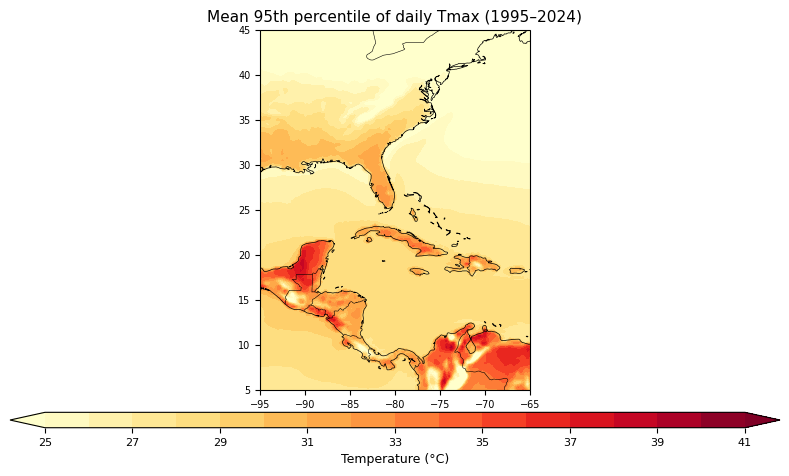

In [44]:

file_percentiles = "tmax2m_percentiles_1995_2024.nc"

ds_percentiles = xr.open_dataset(data_processed_dir + file_percentiles)
p95_mean = ds_percentiles["t2m_p95"].mean(dim="doy")

# Graficar
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={'projection': ccrs.PlateCarree()})

im = ax.contourf(
    ds_percentiles.longitude, ds_percentiles.latitude, p95_mean,
    levels=np.arange(25, 42, 1), cmap="YlOrRd", extend="both", transform=ccrs.PlateCarree()
)

ax.set_title("Mean 95th percentile of daily Tmax (1995–2024)", fontsize=11)
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor='black')
ax.set_xticks(np.arange(-95, -64, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(5, 46, 5), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=7)

# Colorbar
cbar = plt.colorbar(im, orientation="horizontal", pad=0.05, aspect=50)
cbar.set_label("Temperature (°C)", fontsize=9)
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
